# Stochastic Physics-Informed Neural ODEs (SPINODE)

A few key notes:

(1) The code here is tailored to learn neural network representations of hidden physics within stochastic differential equations of the form:

$$ dx = g_1(x,u)dt + \sqrt{2g_2(x,u)} dw, $$

where where $x$ is the system state, $u$ is an exogenous input, $w$ is a Gaussian white noise process, $g_1$ is the drift coefficient, and $g_2$ is the diffusion coefficient. Although the drift and diffusion coefficients represent the underlying physics of the stochastic system, these coefficients may not be known or even measurable in practice. As a result, $g_1$, $g_2$, or individual functions that contribute to $g_1$ and $g_2$ can comprise the the hidden physics of the above equation.

(2) The code uses unscented transform to propagate stochasticity through the above equations although other uncertainty propagation methods can be integrated into the code.

(3) Example data and results are provided for the first case study from the original paper (O'Leary et al., 2022) in the file Data.zip. The first case study is a two-state model for directed colloidal self-assembly with an exogenous input.

In [ ]:
# !rm -rf /content/Heston/Train

In [1]:
!pip install torchdiffeq

In [2]:
# Do not write bytecode to maintain clean directories
import sys
sys.dont_write_bytecode = True

# Import required packages and core code
import numpy as np
import os
import torch
import train

# Specify GPU or CPU use
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Load moment data
# Mean data must be of shape [N, [nx,nu], 1]
# Covariance data must be of shape [N, nx, nx]
# Note that the general methodology can handle higher moments
# --> This code, however, only uses mean and covariance data

mean_i = np.load("Heston/data/mean_initial.npy") # mean at time step k
mean_f = np.load("Heston/data/mean_final.npy") # mean at time step k + 1
cov_i = np.load("Heston/data/cov_initial.npy") # covariance at time step k
cov_f = np.load("Heston/data/cov_final.npy") # covariance at time step k + 1

In [4]:
# Enter relevant system information
nx = 2 # state dimension
nw = 2 # noise dimension
n = nx + nw # augmented state dimension
nu = 0 # exogenous input dimension
dt = 1/252 # sampling time

In [5]:
# Prepare some of the data used to train the neural networks
# that approximate the hidden physics. Note that the "sigma" points come from
# the unscented transform function defined in "utils.py"

# First choose and create path where data will be saved
path = "Heston/Train/"
os.makedirs(path)

# Now prepare data
[sigma_train,
 sigma_val,
 sigma_test,
 mean_f_train,
 mean_f_val,
 mean_f_test,
 cov_f_train,
 cov_f_val,
 cov_f_test,
 W_train,
 W_val,
 W_test,
 sigma_mu,
 sigma_std] = train.prep_data(mean_i,
                              cov_i,
                              mean_f,
                              cov_f,
                              nx,
                              nu,
                              nw,
                              path)

In [6]:
# Set training parameters for neural network that approximates g1
hidden_dim_g1 = 100 # number of hidden nodes
num_hidden_layers_g1 = 2 # number of hidden layers
num_epoch_g1 = 500 # number of epochs
solver_g1 = 'euler' # ode solver
# Note that for the provided data, the 'euler' ODE solver performs the best.
# See O'Leary, et al., 2022 for more details
rtol_g1 = 1e-7 # default value 1e-7
atol_g1 = 1e-9 # default value 1e-9

In [7]:
# Train neural network that approximates g1
model_g1 = train.train_g1(hidden_dim_g1,
                          num_hidden_layers_g1,
                          device,
                          nx,
                          nu,
                          dt,
                          num_epoch_g1,
                          sigma_train,
                          sigma_val,
                          mean_f_train,
                          mean_f_val,
                          W_train,
                          W_val,
                          solver_g1,
                          rtol_g1,
                          atol_g1,
                          path)

Epoch 0000 | Train Loss 0.000055619 | Val Loss 0.000057725
1.0190112590789795
Epoch 0001 | Train Loss 0.000045978 | Val Loss 0.000053720
0.14255690574645996
Epoch 0002 | Train Loss 0.000039039 | Val Loss 0.000049820
0.1470932960510254
Epoch 0003 | Train Loss 0.000036833 | Val Loss 0.000046200
0.13953542709350586
Epoch 0004 | Train Loss 0.000037424 | Val Loss 0.000042781
0.16407227516174316
Epoch 0005 | Train Loss 0.000031316 | Val Loss 0.000039457
0.10149860382080078
Epoch 0006 | Train Loss 0.000028998 | Val Loss 0.000036250
0.09149503707885742
Epoch 0007 | Train Loss 0.000024534 | Val Loss 0.000033103
0.10813379287719727
Epoch 0008 | Train Loss 0.000022570 | Val Loss 0.000030008
0.09567904472351074
Epoch 0009 | Train Loss 0.000019379 | Val Loss 0.000027327
0.09527921676635742
Epoch 0010 | Train Loss 0.000018762 | Val Loss 0.000024907
0.0959327220916748
Epoch 0011 | Train Loss 0.000018756 | Val Loss 0.000022941
0.09226298332214355
Epoch 0012 | Train Loss 0.000014562 | Val Loss 0.000021

In [14]:
import importlib
importlib.reload(train)

<module 'train' from '/content/train.py'>

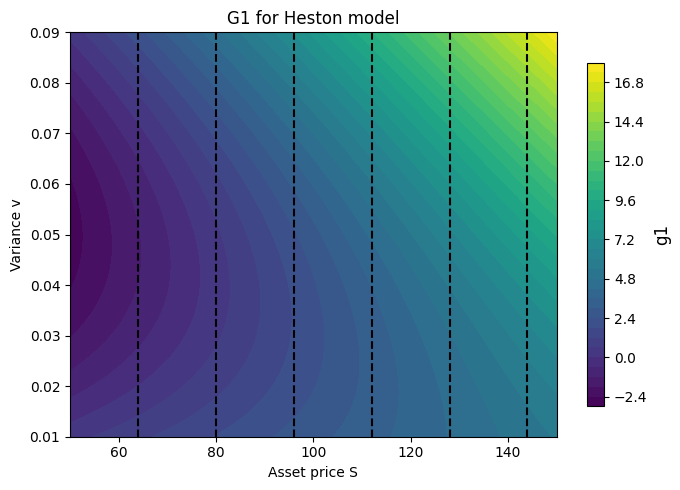

RMSE(g1) = 3.1094


In [15]:
# Reconstruct g1
rmse_g1 = train.reconstruct_Heston('g1',
                               model_g1,
                               device,
                               sigma_mu,
                               sigma_std,
                               nx,
                               nu,
                               dt,
                               path)

In [9]:
# Set training parameters for neural network that approximates g2
hidden_dim_g2 = 100 # number of hidden nodes
num_hidden_layers_g2 = 2 # number of hidden layers
num_epoch_g2 = 500 # number of epochs
solver_g2 = 'euler' # ode solver
# Note that for the provided data, the 'euler' ODE solver performs the best.
# See O'Leary, et al., 2022 for more details
rtol_g2 = 1e-15 # default value 1e-7
atol_g2 = 1e-15 # default value 1e-9

In [10]:
# Prepare target data for training neural network that approximates g2
[g2_target_train,
 g2_target_val,
 g2_target_test] = train.calc_g2_targets(sigma_train,
                                         sigma_val,
                                         sigma_test,
                                         mean_f_train,
                                         mean_f_val,
                                         mean_f_test,
                                         cov_f_train,
                                         cov_f_val,
                                         cov_f_test,
                                         nx,
                                         nu,
                                         nw,
                                         dt,
                                         sigma_mu,
                                         sigma_std,
                                         W_train,
                                         W_val,
                                         W_test,
                                         model_g1,
                                         device,
                                         solver_g1,
                                         rtol_g1,
                                         atol_g1,
                                         path)

In [11]:
# Train neural network that approximates g2
model_g2 = train.train_g2(hidden_dim_g2,
                          num_hidden_layers_g2,
                          device,
                          nx,
                          nu,
                          dt,
                          num_epoch_g2,
                          sigma_train,
                          sigma_val,
                          g2_target_train,
                          g2_target_val,
                          solver_g2,
                          rtol_g2,
                          atol_g2,
                          path)

Epoch 0000 | Train Loss 0.000672354 | Val Loss 0.001454365
0.017191171646118164
Epoch 0001 | Train Loss 0.000755718 | Val Loss 0.001423060
0.013915300369262695
Epoch 0002 | Train Loss 0.000743323 | Val Loss 0.001390225
0.013050556182861328
Epoch 0003 | Train Loss 0.000709918 | Val Loss 0.001356086
0.01328587532043457
Epoch 0004 | Train Loss 0.000727784 | Val Loss 0.001320253
0.013192415237426758
Epoch 0005 | Train Loss 0.000595317 | Val Loss 0.001282453
0.012849569320678711
Epoch 0006 | Train Loss 0.000648908 | Val Loss 0.001243864
0.012902259826660156
Epoch 0007 | Train Loss 0.000634149 | Val Loss 0.001201730
0.012852907180786133
Epoch 0008 | Train Loss 0.000570198 | Val Loss 0.001156272
0.012800455093383789
Epoch 0009 | Train Loss 0.000630693 | Val Loss 0.001108145
0.013177156448364258
Epoch 0010 | Train Loss 0.000607257 | Val Loss 0.001054133
0.012855291366577148
Epoch 0011 | Train Loss 0.000545921 | Val Loss 0.000995650
0.012827873229980469
Epoch 0012 | Train Loss 0.000498518 | Val

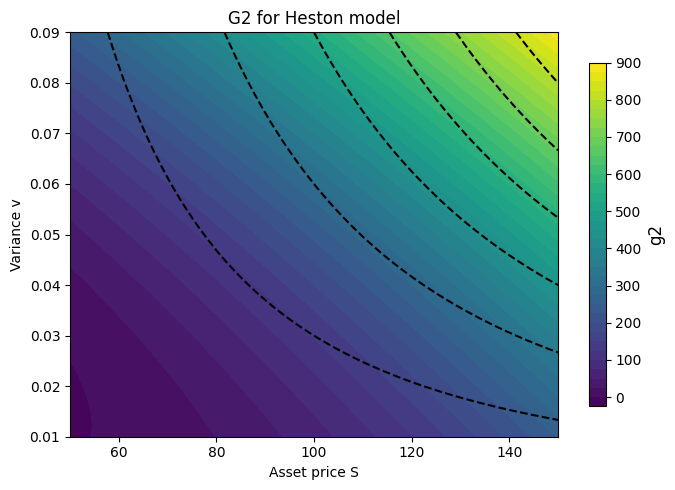

RMSE(g2) = 42.3938


In [16]:
# Reconstruct g2
rmse_g2 = train.reconstruct_Heston('g2',
                                model_g2,
                                device,
                                sigma_mu,
                                sigma_std,
                                nx,
                                nu,
                                dt,
                                path)

In [13]:
import numpy as np
rmse_g1 = np.load("Heston/Train/rmse_g1_Heston.npy")
rmse_g2 = np.load("Heston/Train/rmse_g2_Heston.npy")
print("RMSE(g1):", rmse_g1)
print("RMSE(g2):", rmse_g2)

RMSE(g1): 3.109397941554317
RMSE(g2): 42.39378003560454


___

In [17]:
import os
import zipfile
from google.colab import files

# La ruta de la carpeta que quieres descargar
folder_to_download = 'Heston/Train/'

# Obtener el nombre base de la carpeta para el archivo ZIP
# os.path.normpath maneja las barras finales y os.path.basename extrae el último componente
base_folder_name = os.path.basename(os.path.normpath(folder_to_download))
zip_file_name = f'Heston_{base_folder_name}.zip'

# Crear un archivo ZIP de la carpeta
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for root, dirs, files_in_folder in os.walk(folder_to_download):
        for file in files_in_folder:
            # Crea una ruta relativa para el archivo dentro del ZIP
            arcname = os.path.relpath(os.path.join(root, file), folder_to_download)
            zipf.write(os.path.join(root, file), arcname)

# Descargar el archivo ZIP
print(f'Comprimiendo {folder_to_download} en {zip_file_name} y descargando...')
files.download(zip_file_name)
print('¡Descarga completada!')

Comprimiendo Heston/Train/ en Heston_Train.zip y descargando...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Descarga completada!
